In [1]:
#!sudo /opt/conda/bin/conda install conda-build -y

In [2]:
#!sudo /opt/conda/bin/conda-develop -n QML-QPF PATH /workspaces/QML-QPF/mosaiQue

In [3]:

#import tensorflow as tf
#from tensorflow import keras
import mosaique as mq
from concurrent.futures import ProcessPoolExecutor, as_completed
import itertools
import numpy as np
import pennylane as qml
import os
import time
import datetime
from tensorflow import keras
from mosaique.models.operation import OperationLayer
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

cifar_dataset = keras.datasets.cifar10
train_layer = mq.ConvolutionLayer4x4("cifar_train")
test_layer = mq.ConvolutionLayer4x4("cifar_test")
(train_images, train_labels), (test_images, test_labels) = cifar_dataset.load_data()
train_layer.fit(train_images)
test_layer.fit(test_images)


2024-11-25 16:39:04.685550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 16:39:05.423622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:


def model(variant, tr_layer, te_layer):
    tr_images = tr_layer.open(variant)
    te_images =  te_layer.open(variant)

    log_dir = tr_layer.name + "/run1/" + ''.join(map(str,variant))

    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        write_steps_per_second=True,
        update_freq='batch',
        profile_batch=1,
        embeddings_freq=1,
        embeddings_metadata=None
    )
    q_model = keras.models.Sequential([
        keras.layers.Rescaling(scale=-1. / 127.5, offset=1),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    q_model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    q_history = q_model.fit(
        tr_images,
        train_labels,
        validation_data=(te_images, test_labels),
        batch_size=128,
        epochs=30,
        verbose=2,
        callbacks=[tensorboard_callback]
    )

In [5]:
permutations = np.asarray(list(itertools.permutations(range(4))))

#[model(variant = p, tr_layer = train_layer, te_layer= test_layer) for p in permutations[:1]]

(50000, 16, 16, 4)


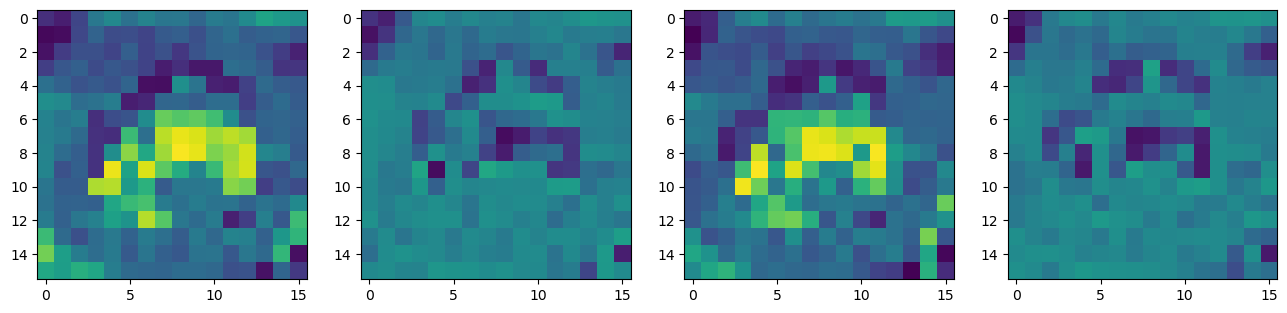

In [6]:
from matplotlib import pyplot as plt

print(train_layer.open([0,1,2,3]).shape)

post = train_layer.open([0,1,2,3])

_min, _max = np.amin(post), np.amax(post)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot all output channels for quantum cnot
for c in range(4):
    axes[c].imshow(post[0,:,:,c],vmin = _min, vmax = _max)

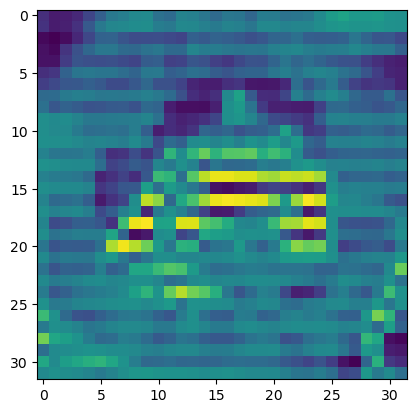

In [7]:
plt.imshow((train_layer.channel_merge(post))[0,:,:],vmin = _min, vmax = _max)

In [8]:

for j in range(3):
    with ProcessPoolExecutor(8) as executor:
        runner = {
            executor.submit(model,variant = p, tr_layer = train_layer, te_layer= test_layer): p for p in permutations[8*j:8*(j+1)]
        }
        for future in as_completed(runner):
            runner.pop(future)
# 1 min 8 sec

2024-11-25 16:39:08.705428: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:08.705530: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:08.709374: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:08.709376: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:08.709453: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:08.709455: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:08.712613: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:08.712682: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:08.727809: I external/local

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30


2024-11-25 16:39:10.235123: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:10.235182: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:10.276497: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:10.276551: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:10.310292: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:10.310435: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:10.330630: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:39:10.330773: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:39:10.348557: I external/local

391/391 - 5s - 12ms/step - accuracy: 0.2819 - loss: 2.0442 - val_accuracy: 0.3060 - val_loss: 1.9887
Epoch 2/30
391/391 - 5s - 13ms/step - accuracy: 0.2799 - loss: 2.0381 - val_accuracy: 0.3131 - val_loss: 1.9753
391/391 - 5s - 13ms/step - accuracy: 0.2810 - loss: 2.0355 - val_accuracy: 0.3095 - val_loss: 1.9794
Epoch 2/30
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2798 - loss: 2.0388 - val_accuracy: 0.3172 - val_loss: 1.9731
Epoch 2/30
391/391 - 6s - 14ms/step - accuracy: 0.2803 - loss: 2.0420 - val_accuracy: 0.3078 - val_loss: 1.9815
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2807 - loss: 2.0448 - val_accuracy: 0.3074 - val_loss: 1.9879
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2779 - loss: 2.0473 - val_accuracy: 0.3008 - val_loss: 1.9926
391/391 - 5s - 14ms/step - accuracy: 0.2856 - loss: 2.0376 - val_accuracy: 0.3086 - val_loss: 1.9799
Epoch 2/30
Epoch 2/30
391/391 - 3s - 7ms/step - accuracy: 0.3144 - loss: 1.9660 - val_accuracy: 0.3181 - val_loss: 1.9653
Epoc

2024-11-25 16:40:36.007976: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:36.008074: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:36.014632: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:36.014716: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:36.015959: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:36.015959: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:36.016036: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:36.016038: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:36.029556: I external/local

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30


2024-11-25 16:40:37.764129: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:37.764187: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:37.768528: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:37.768575: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:37.804550: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:37.804594: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:37.820976: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:40:37.821022: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:40:37.904672: I external/local

391/391 - 5s - 13ms/step - accuracy: 0.2828 - loss: 2.0328 - val_accuracy: 0.3130 - val_loss: 1.9790
Epoch 2/30
391/391 - 5s - 13ms/step - accuracy: 0.2784 - loss: 2.0424 - val_accuracy: 0.3066 - val_loss: 1.9916
Epoch 2/30
391/391 - 5s - 13ms/step - accuracy: 0.2830 - loss: 2.0393 - val_accuracy: 0.3081 - val_loss: 1.9762
Epoch 2/30
391/391 - 5s - 13ms/step - accuracy: 0.2839 - loss: 2.0354 - val_accuracy: 0.3115 - val_loss: 1.9795
Epoch 2/30
391/391 - 5s - 13ms/step - accuracy: 0.2811 - loss: 2.0378 - val_accuracy: 0.3051 - val_loss: 1.9823
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2826 - loss: 2.0388 - val_accuracy: 0.3117 - val_loss: 1.9742
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2815 - loss: 2.0382 - val_accuracy: 0.3064 - val_loss: 1.9861
Epoch 2/30
391/391 - 6s - 15ms/step - accuracy: 0.2812 - loss: 2.0416 - val_accuracy: 0.3046 - val_loss: 1.9795
Epoch 2/30
391/391 - 3s - 6ms/step - accuracy: 0.3209 - loss: 1.9481 - val_accuracy: 0.3201 - val_loss: 1.9559
Epoc

2024-11-25 16:41:59.329148: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:41:59.329623: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:41:59.337153: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:41:59.337153: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:41:59.337228: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:41:59.337232: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:41:59.341224: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:41:59.341331: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:41:59.349537: I external/local

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30


2024-11-25 16:42:00.827096: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:42:00.827149: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:42:00.857424: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:42:00.857471: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:42:00.929949: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:42:00.930108: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:42:00.938291: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-25 16:42:00.938418: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-25 16:42:00.953336: I external/local

391/391 - 5s - 13ms/step - accuracy: 0.2795 - loss: 2.0415 - val_accuracy: 0.3049 - val_loss: 1.9750
Epoch 2/30
391/391 - 5s - 13ms/step - accuracy: 0.2803 - loss: 2.0447 - val_accuracy: 0.2977 - val_loss: 1.9940
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2807 - loss: 2.0402 - val_accuracy: 0.3011 - val_loss: 1.9899
Epoch 2/30
391/391 - 5s - 14ms/step - accuracy: 0.2798 - loss: 2.0437 - val_accuracy: 0.3051 - val_loss: 1.9861
Epoch 2/30
391/391 - 6s - 14ms/step - accuracy: 0.2830 - loss: 2.0365 - val_accuracy: 0.3116 - val_loss: 1.9768
Epoch 2/30
391/391 - 6s - 14ms/step - accuracy: 0.2833 - loss: 2.0340 - val_accuracy: 0.3078 - val_loss: 1.9790
391/391 - 6s - 14ms/step - accuracy: 0.2820 - loss: 2.0381 - val_accuracy: 0.3051 - val_loss: 1.9853
391/391 - 6s - 14ms/step - accuracy: 0.2761 - loss: 2.0515 - val_accuracy: 0.3052 - val_loss: 1.9926
Epoch 2/30
Epoch 2/30
Epoch 2/30
391/391 - 3s - 7ms/step - accuracy: 0.3203 - loss: 1.9507 - val_accuracy: 0.3207 - val_loss: 1.9495
Epoc